In [1]:
import re
import datetime
import numpy as np
from sgp4.api import Satrec, jday

In [2]:
import re
from datetime import datetime, timedelta

# Function to parse the timestamp
def parse_timestamp(timestamp):
    year = int(timestamp[:4])
    day_of_year = int(timestamp[4:7])
    hour = int(timestamp[7:9])
    minute = int(timestamp[9:11])
    second = int(timestamp[11:13])
    millisecond = int(timestamp[14:17])
    dt = datetime(year, 1, 1, hour, minute, second, millisecond * 1000) + timedelta(days=day_of_year - 1)
    return dt


# 파일에서 ephemeris 데이터를 추출하는 함수
def extract_ephemeris_from_text(data):
    # 'UVW' 이후의 데이터를 추출
    match = re.search(r'UVW\n([\s\S]+)', data)
    # print(match)
    if match:
        ephemeris_data = match.group(1).strip()
        # print(f"Extracted Ephemeris Data:\n{ephemeris_data[:500]}")  # 처음 500자를 출력하여 확인
        return ephemeris_data
    else:
        print("No ephemeris data found")
        return None

# Function to extract ephemeris data from text
def extract_ephemeris_from_text(data):
    # Extract data after 'UVW'
    match = re.search(r'UVW\n([\s\S]+)', data)
    if match:
        ephemeris_data = match.group(1).strip()
        return ephemeris_data
    else:
        print("No ephemeris data found")
        return None


# Function to parse the ephemeris data into structured blocks
def parse_ephemeris_data(ephemeris_data):
    lines = ephemeris_data.split('\n')
    blocks = [lines[i:i+4] for i in range(0, len(lines), 4)]

    results = []
    for block in blocks:
        timestamp_line = block[0]
        covariance_lines = block[1:4]

        timestamp, x, y, z, vx, vy, vz = timestamp_line.split()
        parsed_timestamp = parse_timestamp(timestamp)

        covariance_data = ' '.join(covariance_lines).split()
        covariance_data = [float(value) for value in covariance_data]

        result = {
            "timestamp": parsed_timestamp,
            "position":  (float(x), float(y), float(z)),
            "velocity": (float(vx), float(vy), float(vz)),
            "covariance_matrix": covariance_data
        }
        results.append(result)

    return results


In [3]:
# File path to the text file
txt_path = 'Database\MEME_58966_STARLINK-31449_1830216_Operational_1404094620_UNCLASSIFIED.txt'

try:
    with open(txt_path, 'r') as file:
        data = file.read()
        print("File content loaded successfully.")
        ephemeris_data = extract_ephemeris_from_text(data)
        if ephemeris_data:
            print("Ephemeris Data extracted successfully")
            parsed_data = parse_ephemeris_data(ephemeris_data)
            for entry in parsed_data:
                print(entry)
        else:
            print("Failed to extract Ephemeris Data")
except Exception as e:
    print(f"Error reading file: {e}")

File content loaded successfully.
Ephemeris Data extracted successfully
{'timestamp': datetime.datetime(2024, 7, 1, 2, 16, 42), 'position': (-707.5079854914, -6309.0163425706, -2607.4200916418), 'velocity': (4.6786864307, -2.7340293766, 5.3587754167), 'covariance_matrix': [4.7534878702e-07, -3.7878324724e-07, 7.587452019e-07, -2.108104516e-10, 1.0679385267e-10, 1.2038083395e-06, 8.2404228368e-10, -8.9310374782e-10, -8.0547178186e-13, 1.9373285511e-12, -4.6195610813e-10, 3.9889720388e-10, 1.0354579387e-12, -8.1461481428e-13, 4.9695596241e-13, -7.227229694e-13, 7.0478990718e-14, 1.6226099779e-09, -6.3573992037e-16, 1.7426816859e-15, 5.4702272709e-12]}
{'timestamp': datetime.datetime(2024, 7, 1, 2, 17, 42), 'position': (-425.4240324403, -6458.9324939446, -2280.3279852155), 'velocity': (4.7206306313, -2.2612934618, 5.5402504066), 'covariance_matrix': [5.2536427116e-07, -4.4507886091e-07, 8.6541598181e-07, -2.8209240577e-10, 2.1844754854e-10, 1.4123026014e-06, 9.2432946764e-10, -1.035552547

In [4]:
times = []
positions = []
for point in parsed_data:
    times.append(point['timestamp'])
    positions.append(point['position'])

times = np.array(times)
positions = np.array(positions)

In [7]:
times

array([datetime.datetime(2024, 7, 1, 2, 16, 42),
       datetime.datetime(2024, 7, 1, 2, 17, 42),
       datetime.datetime(2024, 7, 1, 2, 18, 42), ...,
       datetime.datetime(2024, 7, 4, 2, 14, 42),
       datetime.datetime(2024, 7, 4, 2, 15, 42),
       datetime.datetime(2024, 7, 4, 2, 16, 42)], dtype=object)

In [6]:
positions

array([[ -707.50798549, -6309.01634257, -2607.42009164],
       [ -425.42403244, -6458.93249394, -2280.32798522],
       [ -141.45131205, -6580.16729302, -1943.08221352],
       ...,
       [-4134.22429014,  -543.5728411 , -5454.04526611],
       [-4114.90542398,  -997.16575601, -5404.2927421 ],
       [-4077.39934055, -1446.3515272 , -5330.58715597]])

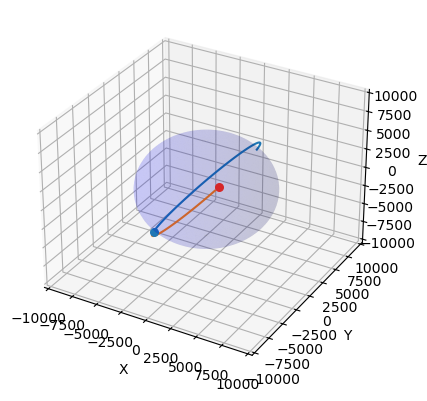

In [5]:
#draw orbit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-10000, 10000)
ax.set_ylim(-10000, 10000)
ax.set_zlim(-10000, 10000)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('auto')
ax.grid(True)

#draw earth sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 6378 * np.outer(np.cos(u), np.sin(v))
y = 6378 * np.outer(np.sin(u), np.sin(v))
z = 6378 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)
ax.plot(positions[times < datetime.now()][-50:, 0], positions[times < datetime.now()][-50:, 1], positions[times < datetime.now()][-50:, 2],color= 'tab:blue')
ax.scatter(positions[times >= datetime.now()][0, 0], positions[times >= datetime.now()][0, 1], positions[times >= datetime.now()][0, 2], color='tab:blue', s=30)
ax.plot(positions[times >= datetime.now()][:30, 0], positions[times >= datetime.now()][:30, 1], positions[times >= datetime.now()][:30, 2],color= 'tab:orange')
ax.scatter(positions[times >= datetime.now()][30, 0], positions[times >= datetime.now()][30, 1], positions[times >= datetime.now()][30, 2], color='tab:red', s=30)
plt.show()
